In [10]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os 
os.chdir("/home/zxz147/git_clones/adversarial-robustness-toolbox/test/de-certification")
import sys
import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from art.attacks.evasion.hop_skip_jump import HopSkipJump
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10, to_categorical

from codes.smoothing.architectures import get_architecture

In [3]:
def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    # npimg = img   # convert from tensor
    # plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    # plt.show()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [4]:
checkpoint_path = "/home/zxz147/git_clones/adversarial-robustness-toolbox/test/de-certification/models/cifar10/resnet110/noise_0.50/checkpoint.pth.tar"
model_architecture = "cifar_resnet110"

In [5]:
base_checkpoint = torch.load(checkpoint_path)
base_classifier = get_architecture(base_checkpoint["arch"], "cifar10")
base_classifier.load_state_dict(base_checkpoint["state_dict"])
# base_classifier.eval()

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_classifier.parameters(), lr=0.01)
pytorch_classifier = PyTorchClassifier(
    model=base_classifier, 
    clip_values=(min_pixel_value, max_pixel_value), 
    loss=criterion, 
    optimizer=optimizer, 
    input_shape=(3, 32, 32), 
    nb_classes=10)

In [35]:
# The prediction results matches the results from the paper, around 60% of the acc. 

predictions = pytorch_classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

predictions = pytorch_classifier.predict(x_train)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
print("Accuracy on benign train examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 60.14000000000001%
Accuracy on benign train examples: 64.7%


Init image (cat): 3


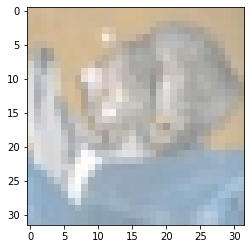

Target image (dog): 5


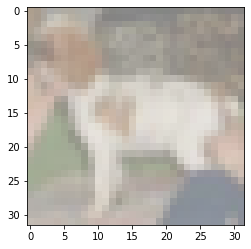

In [6]:
# Obtaining the init (cat) and target (dog) images. 
img_init, img_targ = None, None
imgs_found = [False, False]

for img, label in zip(x_test, y_test):
    if np.argmax(label) == 3 and not imgs_found[0]: 
        img_init = img
        imgs_found[0] = True
    if np.argmax(label) == 5 and not imgs_found[1]: 
        img_targ = img
        imgs_found[1] = True

print("Init image (cat): {}".format(np.argmax(pytorch_classifier.predict(np.expand_dims(img_init, 0)))))
imshow(img_init)
print("Target image (dog): {}".format(np.argmax(pytorch_classifier.predict(np.expand_dims(img_targ, 0)))))
imshow(img_targ)

In [49]:
# HopSkipJump Untargeted Attack, without masking
attack = HopSkipJump(classifier=pytorch_classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = None 
for i in range(20): 
    x_adv = attack.generate(x=np.array([img_targ]), x_adv_init=x_adv, resume=True)
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - img_targ, [-1])),
          "and class label %d." % np.argmax(pytorch_classifier.predict(x_adv)[0]))
    # plt.imshow(x_adv[0])
    # plt.show(block=False)
    
    attack.max_iter = iter_step


Adversarial image at step 0. L2 error 7.70459 and class label 4.



Adversarial image at step 10. L2 error 4.001956 and class label 4.



Adversarial image at step 20. L2 error 2.3624551 and class label 4.



Adversarial image at step 30. L2 error 1.7406193 and class label 4.



Adversarial image at step 40. L2 error 1.4639696 and class label 4.



Adversarial image at step 50. L2 error 1.308728 and class label 4.



Adversarial image at step 60. L2 error 1.1807888 and class label 4.



Adversarial image at step 70. L2 error 1.0883933 and class label 4.



Adversarial image at step 80. L2 error 1.0285068 and class label 4.



Adversarial image at step 90. L2 error 0.9884027 and class label 4.



Adversarial image at step 100. L2 error 0.9533467 and class label 4.



Adversarial image at step 110. L2 error 0.9257924 and class label 4.



Adversarial image at step 120. L2 error 0.9090883 and class label 4.



Adversarial image at step 130. L2 error 0.8864597 and class label 4.



Adversarial image at step 140. L2 error 0.8775178 and class label 4.



Adversarial image at step 150. L2 error 0.86756337 and class label 4.



Adversarial image at step 160. L2 error 0.8548716 and class label 4.



Adversarial image at step 170. L2 error 0.8460522 and class label 4.



Adversarial image at step 180. L2 error 0.8382203 and class label 4.



Adversarial image at step 190. L2 error 0.8336882 and class label 4.


In [50]:
# HopSkipJump Untargeted Attack, without masking
attack = HopSkipJump(classifier=pytorch_classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = None 
mask = np.random.binomial(n=1, p=0.1, size=np.prod(img_targ.shape))
mask = mask.reshape(img_targ.shape)
for i in range(20): 
    x_adv = attack.generate(x=np.array([img_targ]), x_adv_init=x_adv, resume=True)
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - img_targ, [-1])),
          "and class label %d." % np.argmax(pytorch_classifier.predict(x_adv)[0]))
    # plt.imshow(x_adv[0])
    # plt.show(block=False)
    
    attack.max_iter = iter_step


Adversarial image at step 0. L2 error 8.234368 and class label 4.



Adversarial image at step 10. L2 error 4.2260857 and class label 4.



Adversarial image at step 20. L2 error 2.5395172 and class label 4.



Adversarial image at step 30. L2 error 1.8983347 and class label 4.



Adversarial image at step 40. L2 error 1.5705712 and class label 4.



Adversarial image at step 50. L2 error 1.3597726 and class label 4.



Adversarial image at step 60. L2 error 1.2159569 and class label 4.



Adversarial image at step 70. L2 error 1.1325644 and class label 4.



Adversarial image at step 80. L2 error 1.075683 and class label 4.



Adversarial image at step 90. L2 error 1.0194119 and class label 4.



Adversarial image at step 100. L2 error 0.9847687 and class label 4.



Adversarial image at step 110. L2 error 0.95514673 and class label 4.



Adversarial image at step 120. L2 error 0.92639124 and class label 4.



Adversarial image at step 130. L2 error 0.90189505 and class label 4.



Adversarial image at step 140. L2 error 0.88802904 and class label 4.



Adversarial image at step 150. L2 error 0.874768 and class label 4.



Adversarial image at step 160. L2 error 0.8601834 and class label 4.



Adversarial image at step 170. L2 error 0.8514108 and class label 4.



Adversarial image at step 180. L2 error 0.838787 and class label 4.



Adversarial image at step 190. L2 error 0.83319664 and class label 4.


In [8]:
# HopSkipJump targeted Attack, without masking
attack = HopSkipJump(classifier=pytorch_classifier, targeted=True, max_iter=0, max_eval=1000, init_eval=10, verbose=True)
iter_step = 10
x_adv = None 
for i in range(20): 
    x_adv, num_queries = attack.generate(x=np.array([img_targ]), y=to_categorical([5], 10), x_adv_init=x_adv, resume=True)
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - img_targ, [-1])),
          "and class label %d." % np.argmax(pytorch_classifier.predict(x_adv)[0]))
    print(f"Number of queries used: {num_queries}")
    # plt.imshow(x_adv[0])
    # plt.show(block=False)
    
    attack.max_iter = iter_step

ValueError: not enough values to unpack (expected 2, got 1)